# Toy example

This notebook shows how to use the toolkit for explainable AI and fairness. The toy example used is a binary classification trained using lightGBM.

The toolkit uses part, if not all, of the following open-source Python packages:
- `pdpbox`
- `shap`
- `aif360`

The toolkit is model agnostic; the selected functions of the packages should work for models trained by most algorithms.

In [1]:
import json

import numpy as np
import pandas as pd
import lightgbm as lgb
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder
from pdpbox import info_plots
from aif360.metrics.classification_metric import ClassificationMetric

%matplotlib inline
%load_ext autoreload
%autoreload 2

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [3]:
from xai_fairness.toolkit import (
    pdp_plot, actual_plot, target_plot, pdp_interact_plot, 
    prepare_dataset, compute_fairness_measures, color_red,
    get_fairness,
)
from utils import (
    load_pkl, save_pkl, lgb_roc_auc_score
)
from constants import *

## Load data, category_map

In [4]:
NUMERIC_FEATS = [
    'Age',
    'Capital Gain',
    'Capital Loss',
    'Hours per week',
]

CATEGORICAL_FEATS = [
    'Workclass',
    'Education',
    'Marital Status',
    'Occupation',
    'Relationship',
    'Race',
    'Sex',
    'Country',
]

TARGET = "Target"
TARGET_NAMES = ['<=50K', '>50K']

CATEGORY_MAP = json.load(open("data/category_map.txt"))

In [5]:
data = pd.read_csv("data/adult.csv")
data = data[CATEGORICAL_FEATS + NUMERIC_FEATS + [TARGET]]
print(data.shape)
data.head()

(32561, 13)


,Workclass,Education,Marital Status,Occupation,Relationship,Race,Sex,Country,Age,Capital Gain,Capital Loss,Hours per week,Target
0,7,1,1,1,1,4,1,9,39,2174,0,40,0
1,6,1,0,8,0,4,1,9,50,0,0,13,0
2,4,4,2,2,1,4,1,9,38,0,0,40,0
3,4,3,0,2,0,2,1,9,53,0,0,40,0
4,4,1,0,5,5,2,0,6,28,0,0,40,0


In [6]:
# Split train and validation data
raw_train, raw_val = train_test_split(data, random_state=1)
y_train = raw_train[TARGET].values
y_val = raw_val[TARGET].values

## Preprocess

In [7]:
# Apply OHE to categorical features
categories = []
for f in CATEGORICAL_FEATS:
    categories.append(list(range(len(CATEGORY_MAP[f]))))
    
ohe = OneHotEncoder(categories=categories, sparse=False)
ohe_train = ohe.fit_transform(raw_train[CATEGORICAL_FEATS])
ohe_val = ohe.transform(raw_val[CATEGORICAL_FEATS])

In [8]:
# Standardise numeric features to [-1, 1]
minmax_scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_train = minmax_scaler.fit_transform(raw_train[NUMERIC_FEATS])
scaled_val = minmax_scaler.fit_transform(raw_val[NUMERIC_FEATS])

In [9]:
# Concatenate data and set it as pandas.DataFrame.
# Required in order to use PDP and SHAP
OHE_CAT_FEATS = []
for f in CATEGORICAL_FEATS:
    OHE_CAT_FEATS.extend(CATEGORY_MAP[f])

FEATURES = OHE_CAT_FEATS + NUMERIC_FEATS
    
x_train = pd.DataFrame(np.c_[ohe_train, scaled_train].astype(np.float32, copy=False),
                       columns=FEATURES)
x_val = pd.DataFrame(np.c_[ohe_val, scaled_val].astype(np.float32, copy=False),
                       columns=FEATURES)

## Train model

In [10]:
# Train
clf = lgb.LGBMClassifier(
    learning_rate=0.1,
    num_leaves=20,
    n_estimators=100,
)

clf.fit(
    x_train,
    y_train,
    eval_set=[(x_val, y_val)],
    eval_metric=lgb_roc_auc_score,
    verbose=False,
)

LGBMClassifier(num_leaves=20)

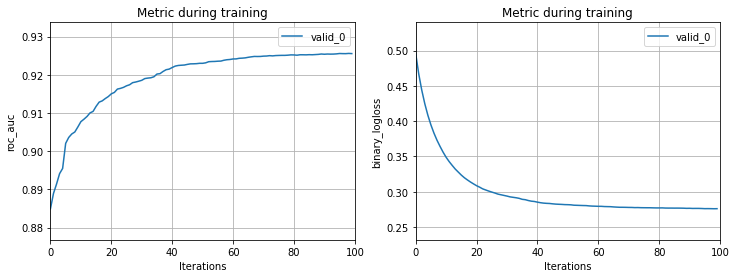

In [11]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
lgb.plot_metric(clf, "roc_auc", ax=axs[0])
lgb.plot_metric(clf, "binary_logloss", ax=axs[1])
plt.show()

# Entry point of explainability tools

- We have written some wrapper functions in `utils.py` to plot partial dependence plots.
- We also demonstrate how to use `SHAP` in our toy example, which one can easily adapt it for their own use cases. SHAP is well maintained and easy to use. User can refer to the SHAP documentation for more details. 
- The requirements for using the toolkit are
  - sample data
  - model

## Sample data

This is to reduce the computation time. The more data is used, the longer the tools will need to process.

In [12]:
np.random.seed(0)
idx = np.random.choice(np.arange(len(x_train)), size=3000, replace=False)

x_sample = x_train.iloc[idx]

sample = x_sample.copy()
sample[TARGET] = y_train[idx]

# Partial Dependence Plots

### 1D Partial Dependence Plots

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


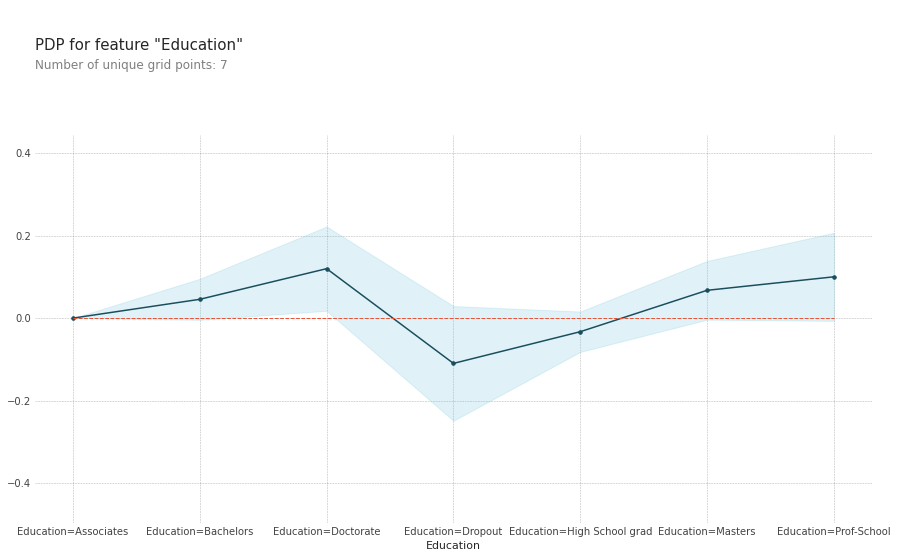

In [12]:
# One-hot encoded feature
feature_name = "Education"
feature = CATEGORY_MAP[feature_name]

fig = pdp_plot(clf, x_sample, FEATURES, feature, feature_name)
# fig, _ = actual_plot(clf, x_sample, feature, feature_name)
# fig, _ = target_plot(sample, feature, feature_name, TARGET)

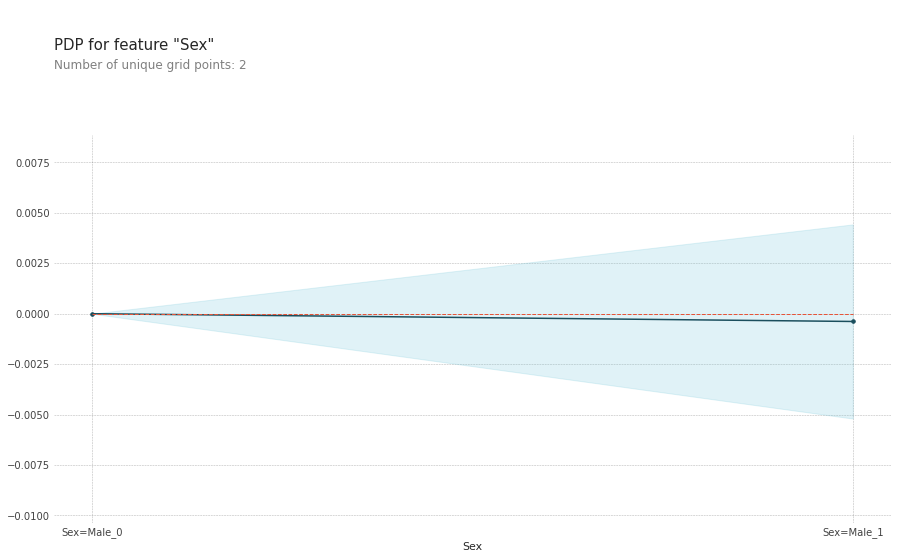

In [13]:
# Binary feature
feature_name = "Sex"
feature = "Sex=Male"

fig = pdp_plot(clf, x_sample, FEATURES, feature, feature_name)
# fig, _ = actual_plot(clf, x_sample, feature, feature_name, show_percentile=True)
# fig, _ = target_plot(sample, feature, feature_name, TARGET)

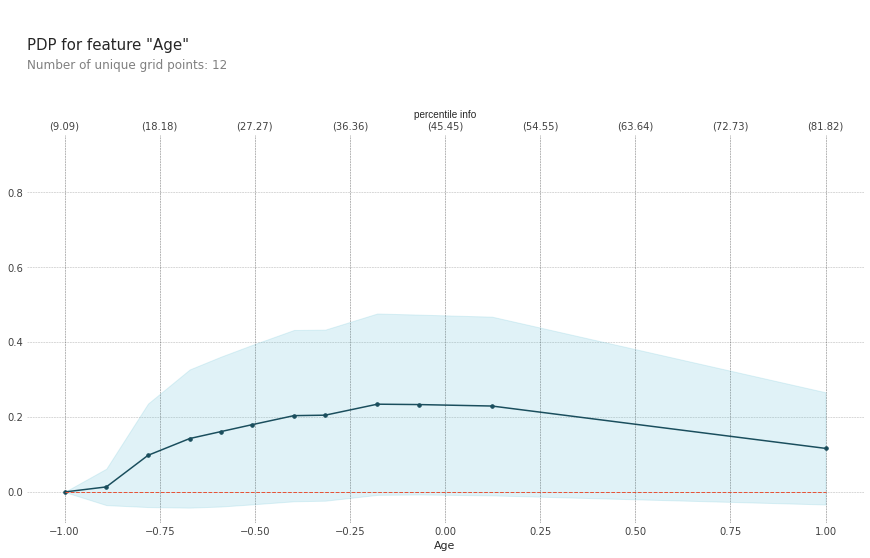

In [14]:
# Continuous feature
feature_name = "Age"
feature = feature_name

fig = pdp_plot(clf, x_sample, FEATURES, feature, feature_name, num_grid_points=12, show_percentile=True)
# fig, _ = actual_plot(clf, x_sample, feature, feature_name, num_grid_points=12, show_percentile=True)
# fig, _ = target_plot(sample, feature, feature_name, TARGET, num_grid_points=12, show_percentile=True)

### 2D Partial Dependence Plots

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


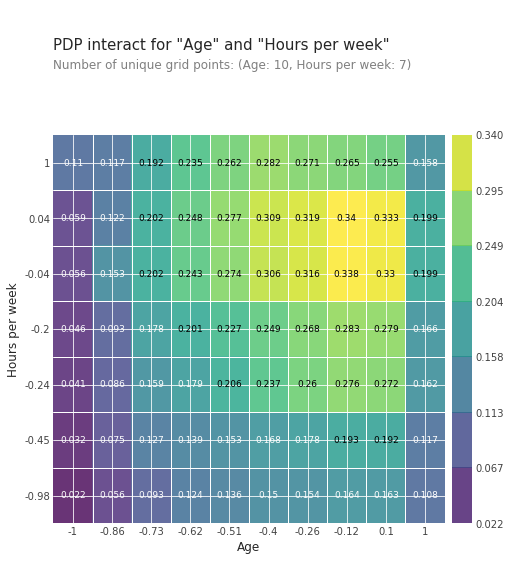

In [15]:
feature1 = 'Age'
feature2 = 'Hours per week'

fig = pdp_interact_plot(clf, x_sample, FEATURES, feature1, feature2)

In [16]:
# fig, axes, summary_df = info_plots.target_plot_interact(
#     sample, [feature1, feature2], [feature1, feature2], TARGET)

# fig, axes, summary_df = info_plots.actual_plot_interact(
#     clf, x_sample, [feature1, feature2], [feature1, feature2])

# SHAP

The SHAP package has explainers for every type of model:
- `shap.TreeExplainer` works with tree-based models (XGBoost/LightGBM/CatBoost/scikit-learn/pyspark models)
- `shap.DeepExplainer` works with Deep Learning models (TensorFlow/Keras models) 
- `shap.KernelExplainer` works with all models, though it is slower than other explainers and it provides only approximation rather than exact Shapley values.

In [16]:
clf = load_pkl("output/lgb.pkl")

sample = pd.read_csv("output/valid.csv")
x_sample = sample[FEATURES]

In [12]:
# LightGBM is used in our toy example, hence TreeExplainer
explainer = shap.TreeExplainer(clf)

### Explain individual instance

In [26]:
row = 6
instance = x_sample.iloc[row: row + 1]

In [27]:
# Predicted probabilities
clf.predict_proba(instance)[0]

array([0.7245577, 0.2754423])

In [28]:
shap_values = explainer.shap_values(instance)[1]
base_value = explainer.expected_value[1]

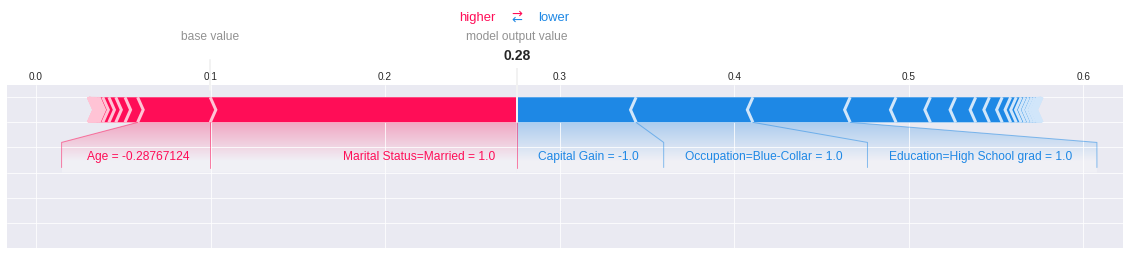

In [29]:
# Visualize the SHAP values using force_plot
shap.force_plot(base_value, shap_values, instance, link='logit', matplotlib=True)

### Summary plot

In [30]:
# Calculate SHAP values
shap_values = explainer.shap_values(x_sample)[1]

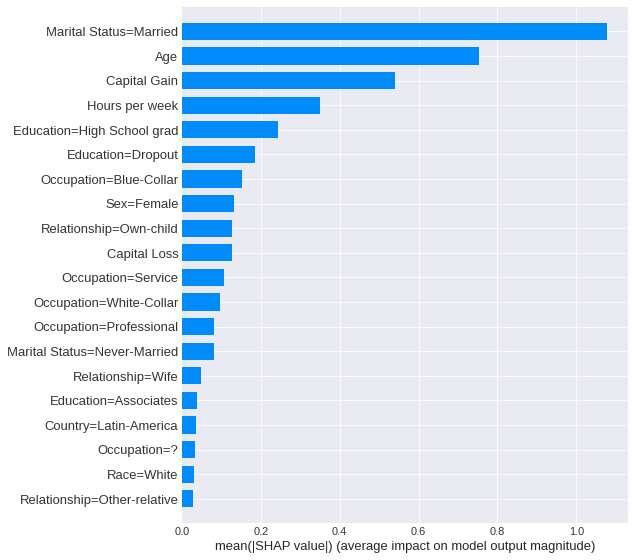

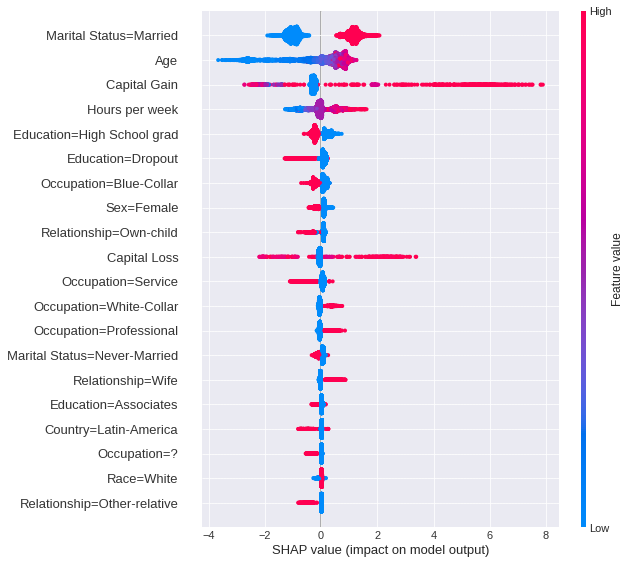

In [31]:
# summarize the effects of all features
shap.summary_plot(shap_values, plot_type="bar", feature_names=FEATURES)
shap.summary_plot(shap_values, x_sample, feature_names=FEATURES)

### SHAP Dependence Contribution Plots

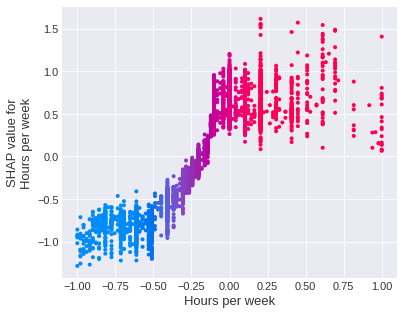

In [34]:
feature = "Hours per week"
interaction_feature = "Hours per week"
shap.dependence_plot(feature, shap_values, x_sample, interaction_index=interaction_feature)

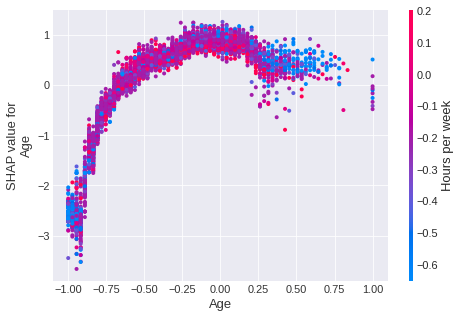

In [32]:
feature = "Age"
interaction_feature = "Hours per week"
shap.dependence_plot(feature, shap_values, x_sample, interaction_index=interaction_feature)

If you don't supply an argument for `interaction_index`, SHAP uses some logic to pick one that may be interesting.

# Entry point for fairness metrics

- In this toy example, the favourable label is '>50K' which corresponds to 1
- Suppose that race is the protected column, and that race=white is the privileged group and the rest forms the unprivileged group. 

**Ensure that the data is not one-hot encoded, so that the helpers can find the privileged and unprivileged groups from the data provided by you.**

In [13]:
clf = load_pkl("data/lgb_clf.pkl")

train = pd.read_csv("data/train.csv")
x_train = train[FEATURES]
y_train = train[TARGET]

valid = pd.read_csv("data/valid.csv")
x_val = valid[FEATURES]
y_val = valid[TARGET]

In [14]:
# Original model performance
y_val_prob = clf.predict_proba(x_val)[:, 1]
y_val_pred = (y_val_prob > 0.5).astype(int)

print(f"Model accuracy = {metrics.accuracy_score(y_val, y_val_pred):.4f}\n")
print(metrics.classification_report(y_val, y_val_pred, digits=4))

Model accuracy = 0.8779

              precision    recall  f1-score   support

           0     0.9062    0.9396    0.9226      6303
           1     0.7628    0.6665    0.7114      1838

    accuracy                         0.8779      8141
   macro avg     0.8345    0.8030    0.8170      8141
weighted avg     0.8738    0.8779    0.8749      8141



In [15]:
# Prepare val dataset
protected_attr = 'Race=White'

grdtruth_val = prepare_dataset(
    x_val, y_val, protected_attr, **CONFIG_FAI[protected_attr])
predicted_val = prepare_dataset(
    x_val, y_val_pred, protected_attr, **CONFIG_FAI[protected_attr])

Fairness is when deviation from 1 is less than 0.2


,Metric,Criterion,All,Unprivileged,Privileged,Ratio,Fair?
0,Equal opportunity,Separation,0.333515,0.413174,0.325554,1.269142,No
1,Predictive parity,Sufficiency,0.762765,0.765625,0.762517,1.004076,Yes
2,Statistical parity,Independence,0.197273,0.107926,0.212509,0.507865,No


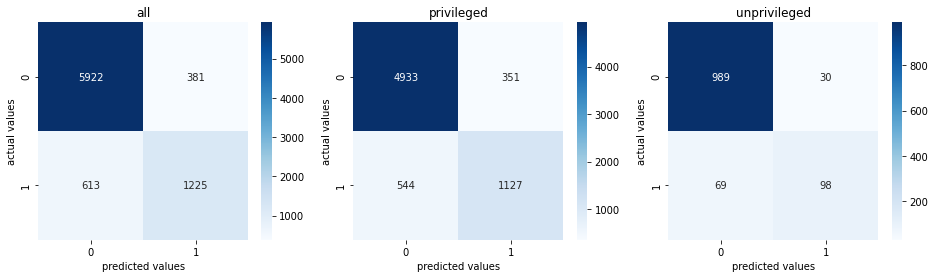

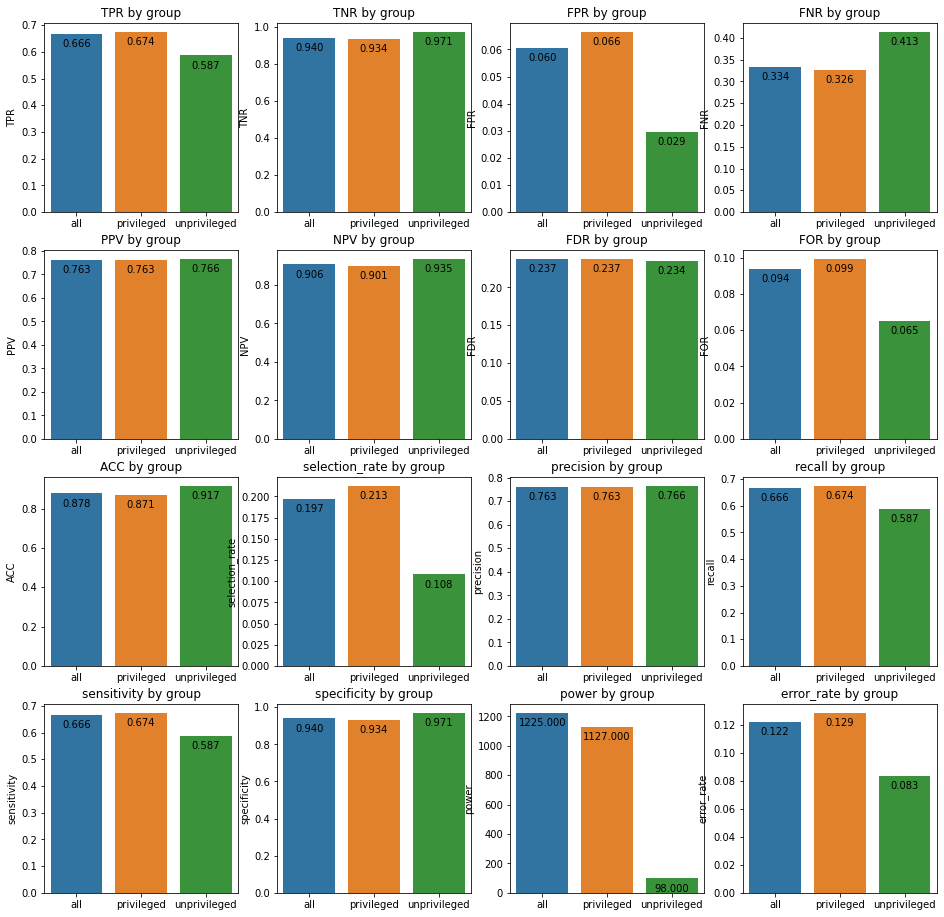

In [16]:
# Compute fairness
fmeasures, fig_confmats, fig_perfs = get_fairness(
    grdtruth_val, predicted_val, protected_attr, **CONFIG_FAI[protected_attr])

# Debiasing

In [13]:
PRIVILEGED_INFO = {
    'unprivileged_groups': [
        {protected_attr: v} for v in 
        CONFIG_FAI[protected_attr]["unprivileged_attribute_values"]],
    'privileged_groups': [
        {protected_attr: v} for v in 
        CONFIG_FAI[protected_attr]["privileged_attribute_values"]],
}
PRIVILEGED_INFO

{'unprivileged_groups': [{'Race=White': 0}],
 'privileged_groups': [{'Race=White': 1}]}

In [16]:
# Prepare train dataset
y_train_prob = clf.predict_proba(x_train)[:, 1]
y_train_pred = (y_train_prob > 0.5).astype(int)

grdtruth_train = prepare_dataset(
    x_train, y_train, protected_attr, **CONFIG_FAI[protected_attr])
predicted_train = prepare_dataset(
    x_train, y_train_pred, protected_attr, **CONFIG_FAI[protected_attr])

# Debiasing: calibrated equal odds

We demonstrate a form of debiasing here using calibrated equal odds.
- Optimizes for TPR/FPR difference and improves calibration.
- Requires only model predictions as input, so no need to retrain anything
- But no option to tweak fairness-accuracy tradeoff

In [17]:
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing

In [18]:
# Train
calibrator = CalibratedEqOddsPostprocessing(**PRIVILEGED_INFO, seed=0)

calibrator.fit(grdtruth_train, predicted_train)

# Predict using calibrator
adj_pred_val = calibrator.predict(predicted_val)

In [21]:
y_val_adj = adj_pred_val.labels

# Compute accuracy after debiasing
print(f"Model accuracy = {metrics.accuracy_score(y_val, y_val_adj):.4f}\n")
print(metrics.classification_report(y_val, y_val_adj, digits=4))

Model accuracy = 0.8613

              precision    recall  f1-score   support

           0     0.8813    0.9486    0.9137      6303
           1     0.7612    0.5620    0.6466      1838

    accuracy                         0.8613      8141
   macro avg     0.8213    0.7553    0.7802      8141
weighted avg     0.8542    0.8613    0.8534      8141



Fairness is when deviation from 1 is less than 0.2


,Metric,Criterion,All,Unprivileged,Privileged,Ratio,Fair?
0,Equal opportunity,Separation,0.437976,0.413174,0.440455,0.938061,Yes
1,Predictive parity,Sufficiency,0.761238,0.765625,0.760781,1.006367,Yes
2,Statistical parity,Independence,0.166687,0.107926,0.176707,0.610760,No


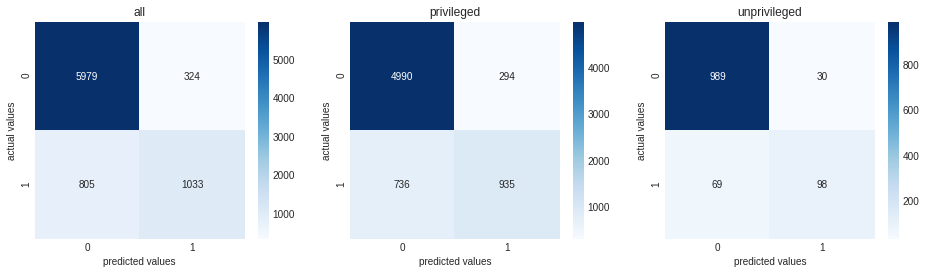

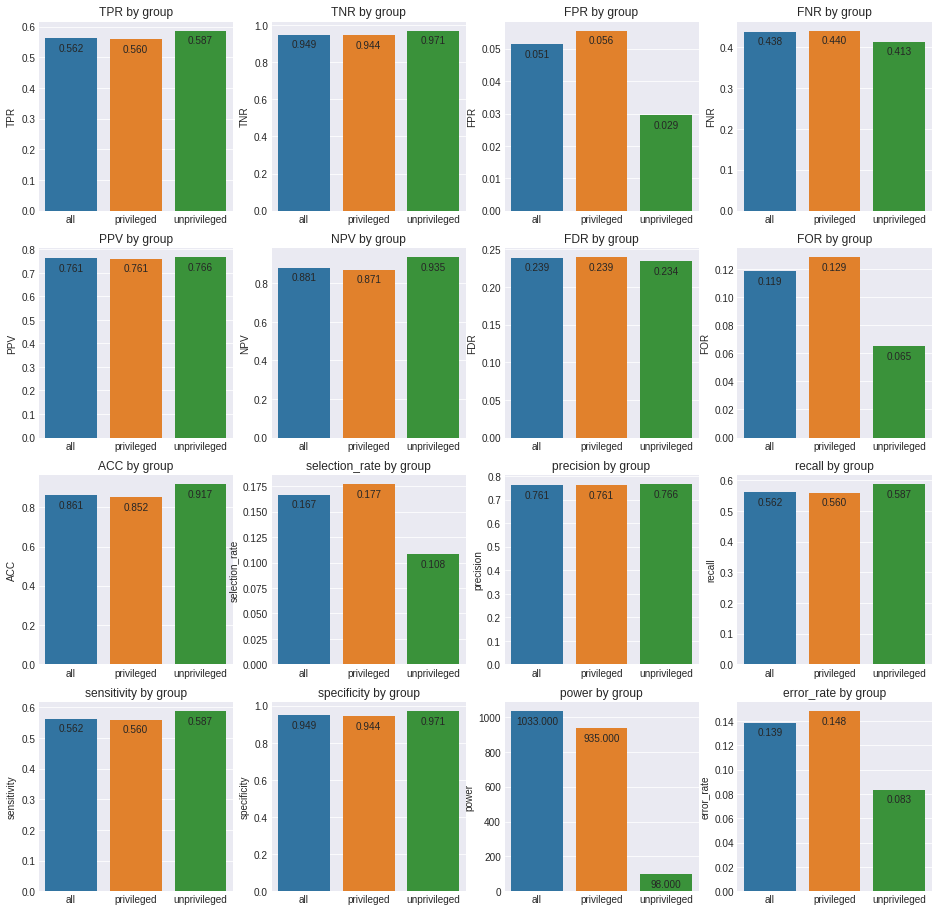

In [24]:
# Compute fairness
fmeasures, fig_confmats, fig_perfs = get_fairness(
    grdtruth_val, adj_pred_val, protected_attr, **CONFIG_FAI[protected_attr])

# Debiasing: adversarial debiasing

In [25]:
import tensorflow as tf
from aif360.algorithms.inprocessing import AdversarialDebiasing

In [26]:
# Train
model_params = {
    'classifier_num_hidden_units':200, 
    'num_epochs':20,
    'batch_size':128,
    'adversary_loss_weight':0.1,
    'debias':True,
    'seed':1234,
}

with tf.Session() as sess:
    debias_clf = AdversarialDebiasing(scope_name='debiased_classifier', sess=sess, **PRIVILEGED_INFO, **model_params)
    debias_clf.fit(grdtruth_train)
    
    # Predict using debiased classifier
    adj_pred_val = debias_clf.predict(grdtruth_val)




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





epoch 0; iter: 0; batch classifier loss: 0.622046; batch adversarial loss: 0.707797
epoch 1; iter: 0; batch classifier loss: 0.361270; batch adversarial loss: 0.631521
epoch 2; iter: 0; batch classifier loss: 0.358781; batch adversarial loss: 0.547015
epoch 3; iter: 0; batch classifier loss: 0.429012; batch adversarial loss: 0.510223
epoch 4; iter: 0; batch classifier loss: 0.393672; batch adversarial loss: 0.471113

In [27]:
y_val_adj = adj_pred_val.labels

# Compute accuracy after debiasing
print(f"Model accuracy = {metrics.accuracy_score(y_val, y_val_adj):.4f}\n")
print(metrics.classification_report(y_val, y_val_adj, digits=4))

Model accuracy = 0.8600

              precision    recall  f1-score   support

           0     0.8925    0.9313    0.9115      6303
           1     0.7231    0.6153    0.6649      1838

    accuracy                         0.8600      8141
   macro avg     0.8078    0.7733    0.7882      8141
weighted avg     0.8543    0.8600    0.8558      8141



Fairness is when deviation from 1 is less than 0.2


,Metric,Criterion,All,Unprivileged,Privileged,Ratio,Fair?
0,Equal opportunity,Separation,0.384657,0.431138,0.380012,1.134537,Yes
1,Predictive parity,Sufficiency,0.723146,0.714286,0.723969,0.986624,Yes
2,Statistical parity,Independence,0.192114,0.112142,0.205751,0.545035,No


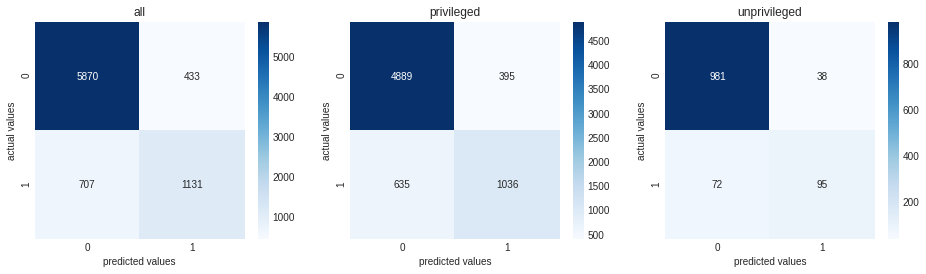

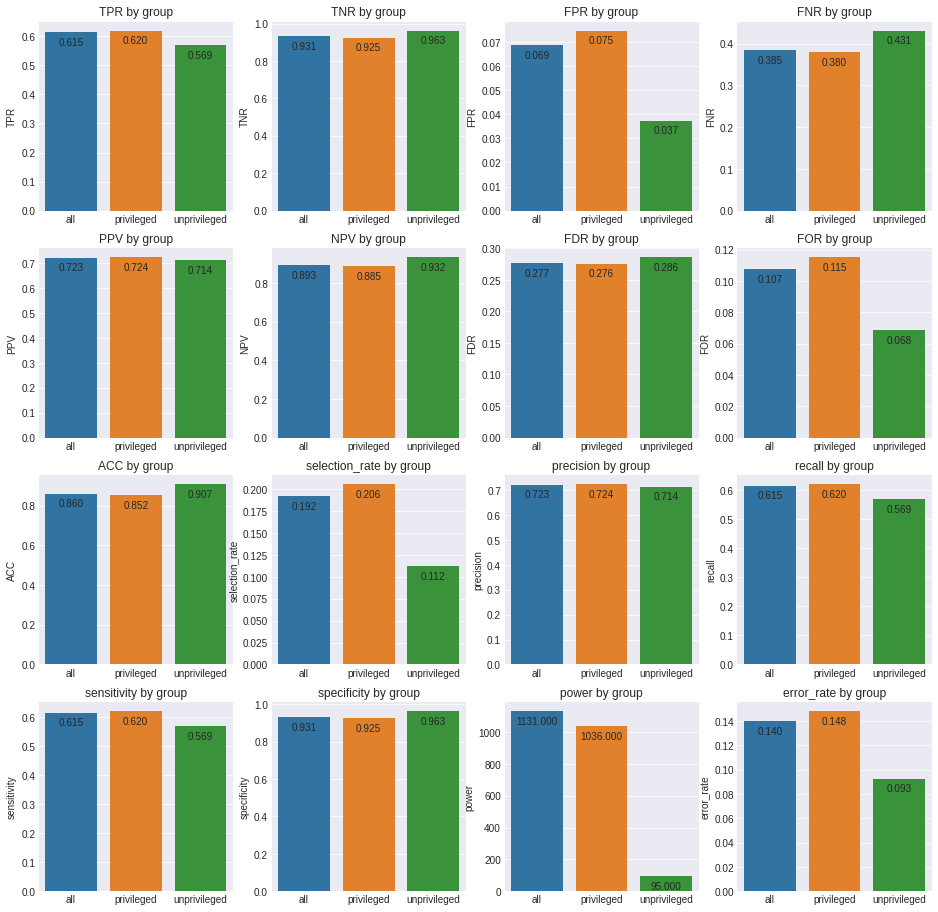

In [28]:
# Compute fairness
fmeasures, fig_confmats, fig_perfs = get_fairness(
    grdtruth_val, adj_pred_val, protected_attr, **CONFIG_FAI[protected_attr])

In [29]:
sess.close()
tf.reset_default_graph()